<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px"> 

#   Project 4: Detecting Hate Speech

> SG-DSI-41 Group 01: Lionel Foo, Joel Lim, Poon Wenzhe, Daryl Chia

---


#### <b> Notebook: 02A-M2 Classification Model (Multiclass Classification - RNN with GloVe Word Embeddings) </b>

<b>(a) Context: Rationale for Incorporating GloVe Word Embeddings</b>

Keras' default word vectorisation approach is non-semantic by nature (i.e., word vectors produced do not reflect how semantically close/far apart words are from each other). [1]

GloVe word embeddings will thus be incorporated in our model to enable semantic-based word vectorisation - with the view towards improving the classification model's performance. However, as GloVe's word embeddings are static (i.e., the same word will always have the same representation regardless of the context where it occurs - GloVe treats "apple" in "apple computers" and "apple juice" similarly) - word vectorisation with GloVe does not allow for context-driven semantic word vectorisation. [2] 

<font size="1.5">

References: 

[1] Towards Data Science. Text Classification using Word Embeddings and Deep Learning in Python - Classifying Tweets from .... 
<br>https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

[2] David Batista. Language Models and Contextualised Word Embeddings.
<br>https://www.davidsbatista.net/blog/2018/12/06/Word_Embeddings/

</font>

<br>
<b>(b) Incorporating GloVe Word Embeddings - Text-Preprocessing: Retention of Stop Words and No Lemmatisation</b>

A review of words within the GloVe repository reveals the presence of: 
* Stop words (e.g., "to", "but", "not")
* Words with similar lemmas that have different word vectors (e.g., "computer", "computerized", "supercomputers")

As such, stop words will be retained, and lemmatisation will not be performed. 

<br>
<b>(c) Notebook Outline</b>

1. Import Libraries, Data & Specify Random Seeds
2. Prepare Data for Modelling
3. Construct GloVe Word Embedding Matrix
4. Train Classification Model
5. Evaluate Classification Model
6. Comparison of Model Performance - Multinomial Classifier: w/out and w GloVe-based Word Vectoriser
7. Key Insights & Steps Going Forward


---

<b> 1. Import Libraries, Data & Specify Random Seeds </b>

In [1]:
# Imports: standard
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import joblib

# Imports: tensorflow for model building
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from keras.models import Sequential
# from keras.layers import Embedding

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

In [2]:
# Import data
df = pd.read_csv("data/hate-speech-and-offensive-language-dataset_cleaned.csv")
df.head(3)

,class,tweet
0,2,as a woman you should not complain about cleaning up your house as a man you should always take the trash out
1,1,boy dats cold tyga dwn bad for cuffin dat hoe in the st place
2,1,dawg you ever fuck a bitch and she start to cry you be confused as shit


In [3]:
# Specify Random Seeds
np.random.seed(42)
tf.random.set_seed(42)


---

<b> 2. Prepare Data for Modelling </b>

Outline
* (a) Evaluate Class Imbalance
* (b) Perform Train-Test-Split
* (c) Address Class Imbalance
* (d) Tokenise & Pad Text Sequences

<b> (a) Evaluate Class Imbalance </b>

In [4]:
# 1. Create X (teatures) and y (target)
X = df['tweet']
y = df['class']

In [5]:
# 2. Evaluate class imbalance
print("== Examine Class Imbalance ==", "\n")

print("= Counts =", "\n")
print(y.value_counts(), "\n")

print("= Proportions =", "\n")
print(y.value_counts(normalize = True))

== Examine Class Imbalance == 

= Counts = 

class
1    19187
2     4158
0     1428
Name: count, dtype: int64 

= Proportions = 

class
1    0.774513
2    0.167844
0    0.057643
Name: proportion, dtype: float64


Comments: Class Imbalance
* Class [0]: Hate Speech ; Class [1]: Offensive Language, Class [2]: Neither
* There are a disproportionately low number of "hate speech" (5.8%) and "neither" (16.8%) tweets

Comments: Approach to Addressing Class Imbalance
* Undersampling (oversampling) of the most (least) numerous class to attain a tweet count equivalent to the "neither" class (as it has a tweet count between both classes), where we'll:
    * undersample: the most numerous class ("offensive language") 
    * oversample: the least numerous class ("hate speech)

* To prevent "training" data from leaking into the "testing" data - the class rebalancing procedure will be applied:
    * after the "train-test-split" step, and
    * applied to the "training" sample only

<b> (b) Perform Train-Test-Split </b>

In [6]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<br>
<b> (c) Address Class Imbalance </b>

Recall Approach: Rebalance Classes within the "Training" Sample Only

* Undersampling (oversampling) of the most (least) numerous class to attain a tweet count equivalent to the "neither" class (as it has a tweet count between both classes), where we'll:
    * undersample: the most numerous class ("offensive language") 
    * oversample: the least numerous class ("hate speech)

In [7]:
# Perform Class Rebalancing on "Training" Data

# 1. Temporarily Concatenate X_train and y_train (Column-to-Column)
df_train = pd.concat(objs=[X_train,y_train], axis=1)

# 2. Perform Rebalancing
class_2 = df_train[df_train["class"] == 2]
class_1 = df_train[df_train["class"] == 1].sample(n=3350, random_state=42)
class_0 = df_train[df_train["class"] == 0]

df_train_balanced = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# 3. Check For Class Balance
print("== Examine Class Balance : Proportions ==", "\n")
print(df_train_balanced["class"].value_counts(normalize=True))

== Examine Class Balance : Proportions == 

class
0    0.339337
1    0.331519
2    0.329144
Name: proportion, dtype: float64


In [8]:
# Perform Class Rebalancing on "Training" Data (Cont'd)

# 4. Add balanced: X_train_bal, y_train_bal
X_train_bal = df_train_balanced["tweet"]
y_train_bal = df_train_balanced["class"]

# 5. Check that X_train_bal "tweets" are treated as strings
print("X_train_bal data type:", X_train_bal.dtype)

X_train_bal data type: object


In [9]:
# Dummify "training" and "testing" data's target
# > as we have multiple class categories

y_train_bal_i = y_train_bal.copy()
y_test_i = y_test.copy()

y_train_bal = pd.get_dummies(y_train_bal)
y_test      = pd.get_dummies(y_test)

print("Shape y_train_bal:", y_train_bal.shape)
print("Shape y_test:", y_test.shape)

Shape y_train_bal: (10105, 3)
Shape y_test: (4955, 3)


<br>
<b> (d) Tokenise & Pad Text Sequences </b>

In [10]:
# Perform Tokenisation

# 1. Initialise tokeniser and fit tokeniser on training data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

# 2. Use that tokenizer to transform (convert) the text message strings in training and test data into a list of integers where each integer represents the index of that word
X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [11]:
# Pad Text Sequences

# 1. Obtain maximum length of text sequences in X_train and X_test
max_len_train = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train_bal))
max_len_test  = max(len(seq) for seq in tokenizer.texts_to_sequences(X_test))
max_len = max(max_len_train, max_len_test)

print("Max sequence length:", max_len)

# 2. Pad Text Sequences
X_train_bal_seq_padded = pad_sequences(X_train_bal_seq, max_len)
X_test_seq_padded = pad_sequences(X_test_seq, max_len)

# 3. Preview padded text sequence
print("Preview padded text sequence:")
print(X_test_seq_padded[0])

Max sequence length: 37
Preview padded text sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 1589  160   25
  244   60  447  412    1  465   19   11   45]


<br>

---

<b> 3. Construct GloVe Word Embedding Matrix </b>

As keras' default process to vectorise text sequencess is not semantics-based, a semantics-based approach utilising GloVe word embeddings will be adopted. 


(a) This step produces a GloVe Word Embedding Matrix required for semantics-based vectorisation, with guidance having been obtained from:
* Towards Data Science. Text Classification using Word Embeddings and Deep Learning in Python - Classifying Tweets from ... .
* <font size="1.5"> weblink: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81 </font>
<br>

(b) Details: GloVe Pre-Trained Word Embeddings Utilised
* As our data comprise twitter tweets, a GloVe Word Embedding that was pre-trained on 2 billion tweets will be utilised
* While word embedding vectors of dimensions 50d, 100d, & 200d are available, embeddings with <u>200d</u> will be used to capture finer differences between words' semantic meaning
* <font size="1.5"> weblink: https://nlp.stanford.edu/projects/glove/ </font>
* <font size="1.5"> download link: https://nlp.stanford.edu/data/glove.twitter.27B.zip </font>
<br>

(c) Broad Outline of Steps Required to Construct the GloVe Word Embedding Matrix
1. Recall tokenised "training" data
2. Create a parsimonious GloVe Word Embedding Matrix containing vectorised forms of the "training" data's tokens only 
    * i.e., other words within GloVe's word embeddings repository are excluded as they are not relevant to our analysis; and their exclusion allows us to conserve as much memory as possible
    * code for creating the parsimonious GloVe Word Embedding Matrix: drawn from the "Towards Data Science" article referenced above

In [12]:
# 1. Recall tokenised "training" data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

In [13]:
# 2. Define a class to create a parsimonious GloVe Word Embedding Matrix
# code source: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

class Embeddings():

    # A class to read a given word embedding file and to create a parsimonious word embedding matrix

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
    
        # A method to create the embedding matrix
        
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue

        return embedding_matrix

In [14]:
# 3. Create parsimonious GloVe Word Embedding Matrix

embed_path = "data/glove.twitter.27B.200d.txt"
embed_dim = 200  # corresponding to the number of dimensions per word in the GloVe repository above 

embedding = Embeddings(embed_path, embed_dim)
embedding_matrix = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))


---

<b> 4. Train Classification Model </b>

1. Define Model
2. Define callbacks
3. Fit the RNN model

In [15]:
# 1. Define a RNN-LSTM model architecture using Keras
model = keras.models.Sequential([
    
    layers.Embedding(len(tokenizer.index_word)+1, embed_dim, weights=[embedding_matrix]),  # weights from: parsimonious GloVe Word Embedding Matrix

    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])
# Configure the model with Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2265800   
                                                                 
 bidirectional (Bidirection  (None, 64)                59648     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [16]:
# 2. Define callbacks

# EarlyStopping callback to stop training if 'val_accuracy' doesn't improve for 10 consecutive epochs,
# Restoring the weights of the epoch with the best validation accuracy.
es = EarlyStopping(patience=10,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
# Reduce learning rate by a factor of 0.5 if 'val_loss' doesn't improve for 5 consecutive epochs.   
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [17]:
# 3. Fit the RNN model
history = model.fit(X_train_bal_seq_padded, y_train_bal,
                    validation_data=(X_test_seq_padded, y_test),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50


316/316 [==============================] - 5s 13ms/step - loss: 1.1163 - accuracy: 0.7452 - val_loss: 0.9313 - val_accuracy: 0.7582 - lr: 0.0010
Epoch 2/50
316/316 [==============================] - 4s 12ms/step - loss: 0.5001 - accuracy: 0.8790 - val_loss: 0.5344 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 3/50
316/316 [==============================] - 4s 13ms/step - loss: 0.2709 - accuracy: 0.9318 - val_loss: 0.4681 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 4/50
316/316 [==============================] - 4s 14ms/step - loss: 0.1614 - accuracy: 0.9614 - val_loss: 0.5600 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 5/50
316/316 [==============================] - 5s 15ms/step - loss: 0.1096 - accuracy: 0.9744 - val_loss: 0.6042 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 6/50
316/316 [==============================] - 4s 13ms/step - loss: 0.0816 - accuracy: 0.9801 - val_loss: 0.8836 - val_accuracy: 0.7974 - lr: 0.0010
Epoch 7/50
316/316 [==============================] - 4s 13ms/step - loss: 


---

<b> 5. Evaluate Classification Model </b>

(a) Evaluate loss and accuracy epoch-by-epoch

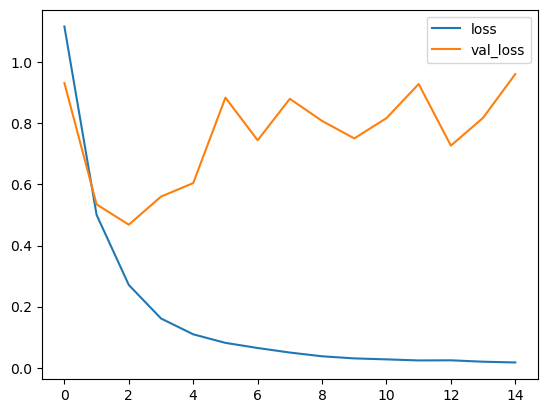

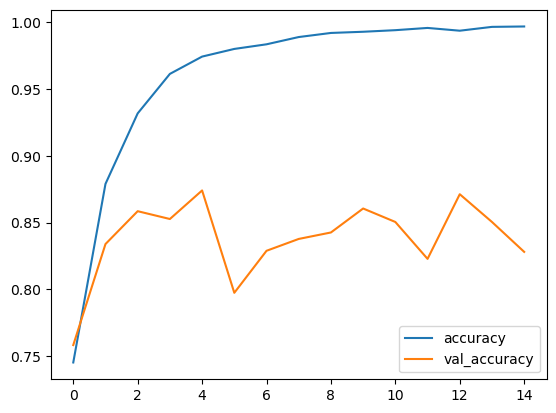

In [18]:
# Graph: loss and accuracy epoch-by-epoch
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [19]:
# Table: loss and accuracy epoch-by-epoch
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,1.116309,0.745176,0.931270,0.758224,0.00100
1,0.500141,0.878971,0.534408,0.833905,0.00100
2,0.270926,0.931816,0.468106,0.858527,0.00100
3,0.161384,0.961405,0.559978,0.852674,0.00100
4,0.109590,0.974369,0.604195,0.874067,0.00100
5,0.081616,0.980109,0.883627,0.797376,0.00100
6,0.064889,0.983572,0.744206,0.828860,0.00100
7,0.049969,0.989015,0.879745,0.837740,0.00100
8,0.037737,0.992083,0.807509,0.842583,0.00050
9,0.030833,0.992974,0.750288,0.860545,0.00050


In [20]:
# Identify best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print("Best epoch: ", best_epoch)

Best epoch:  5


(b) Obtain model evaluation metrics

In [21]:
# Define function: generate predicted classes as a numpy array

def pred_class(pred_prob_varname):

    pred_class_all = np.array([])
    for pred_prob_array in pred_prob_varname:
        pred_class = np.argmax(pred_prob_array)
        pred_class_all = np.append(pred_class_all, pred_class)
    
    return pred_class_all

In [22]:
# Obtain predicted probabilities and classes
y_train_pred_prob  = model.predict(X_train_bal_seq_padded)
y_train_pred_class = pred_class(y_train_pred_prob)

y_test_pred_prob  = model.predict(X_test_seq_padded)
y_test_pred_class = pred_class(y_test_pred_prob)

184/316 [================>.............] - ETA: 0s

155/155 [==============================] - 0s 3ms/step


In [23]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train_bal_i, y_train_pred_class, target_names = ["class 0", "class 1", "class 2"]))

== Classification Report: Training Data == 

              precision    recall  f1-score   support

     class 0       0.99      0.97      0.98      3429
     class 1       0.97      0.99      0.98      3350
     class 2       0.98      1.00      0.99      3326

    accuracy                           0.98     10105
   macro avg       0.98      0.98      0.98     10105
weighted avg       0.98      0.98      0.98     10105



In [24]:
# Print model evaluation metrics: "testing" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test_i, y_test_pred_class, target_names = ["class 0", "class 1", "class 2"]))

== Classification Report: Testing Data == 

              precision    recall  f1-score   support

     class 0       0.36      0.47      0.41       285
     class 1       0.96      0.89      0.92      3838
     class 2       0.77      0.94      0.85       832

    accuracy                           0.87      4955
   macro avg       0.70      0.76      0.73      4955
weighted avg       0.89      0.87      0.88      4955



<b>Comments</b>

Performance on: "Training" Data
* The model performs well across all evaluation metrics and across all classes, with (a) precision, (b) recall, (c) f1-score and (d) overall accuracy being > 0.90 

Performance on: "Testing" Data
* The model predicts class 1 ("offensive language") and class 2 ("neither) tweets well, with (a) "precision" and (b) "recall", (c) "f1-scores" being > 0.8
* While the model's predictive performance on class 0 ("hate speech") fares better than a model without the GloVe-based word vectoriser, 
    * it still does not predict class 0 ("hate speech) well, with relatively low "precision" and "recall" scores

<br>

---

<b>6. Comparison of Model Performance - Multinomial Classifier: w/out and w GloVe-based Word Vectoriser</b>

(a) Evaluation Metrics of Interest

* Accuracy: % of predictions that are correct 

* F1-Score: Composite measure that considers both (i) “precision” and (ii) “recall”

    * “precision”: % of predicted “positives” that are true
        * Relevant as a low precision score on detecting hate speech indicates that we are wrongly censoring non-hate speech that could be of interest to readers

    * “recall”: % of actual “positives” that are predicted correctly
        * Relevant as we wish to identify as high a proportion of hate speech that exists
<br>

(b-1) Training Data

|w/out GloVe|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.93|---|3429|
|Class 1: Offensive|0.94|---|3350|
|Class 2: Neither|0.97|---|3326|
|Overall|---|0.95|10105|

<br>

|w GloVe|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.97|---|3429|
|Class 1: Offensive|0.96|---|3350|
|Class 2: Neither|0.99|---|3326|
|Overall|---|0.97|10105|


(b-2) Testing Data

|w/out GloVe|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.40|---|285|
|Class 1: Offensive|0.91|---|3838|
|Class 2: Neither|0.82|---|832|
|Overall|---|0.86|4955|

<br>

|w GloVe|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.40|---|285|
|Class 1: Offensive|0.93|---|3838|
|Class 2: Neither|0.86|---|832|
|Overall|---|0.88|4955|

*note: scores may vary from code re-run to re-run*

<br>

---

<b>7. Key Insights & Steps Going Forward</b>

* Use of a GloVe-based word vectoriser improves model performance - in line with the fact that it helps account for semantic differences across texts.
* It is challenging to separably identify "hate speech", considering that it comprises the original/"test" dataset's minority class 
* Going forward:
    * Continue to use a GloVe-based word vectoriser
    * Collapse "hate speech" and "offensive language" categories, as a "hurtful comments" category


---